# Introducción al manejo de datos geográficos

# Geopandas II

## Operaciones espaciales

Los dataframes en geopandas no son otra cosa que una base de datos. Como las que venimos manipulando en pandas. Ahora bien, estas se distinguen por la presencia de un atributo que los dataframes comunes no cuentan: una `geometría`. Esta define tanto el tipo de objeto como las operaciones espaciales soportadas. 

Para cargar un geodataframe contamos con distintas alternativas. Podríamos leer un archivo de tipo `shp` como así también interpretar una geometría desde un cuerpo de texto o bien a partir de coordenadas geogŕaficas. 

In [1]:
from google.colab import drive

In [2]:
drive.mount('/drive/')

Mounted at /drive/


In [3]:
!apt install libspatialindex-dev
!pip install rtree
!pip install geopandas

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (830 kB/s)
Selecting previously unselected package libspatialindex

### Polígonos, los barrios de la Ciudad desde WKT

In [4]:
import geopandas as gpd

Lo que hacemos en la siguiente sección, es interpretar una `geometría` desde el modulo well known text (wkt) de shapely. Digamos que estaríamos leyendo un archivo de tipo `shp` como si este fuera un `csv`.

In [17]:
import pandas as pd
from shapely import wkt

In [7]:
#!unzip '/drive/MyDrive/IT - UNSAM/datos/barrios_caba.zip'
a = gpd.read_file('/drive/MyDrive/IT - UNSAM/datos/barrios_caba.zip')

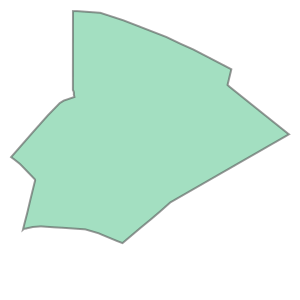

In [15]:
a.geometry[0]

In [19]:
# este sería nuestro shapefile, con la serie "geometria" almacenada como objeto de tipo texto. 
barrios_wkt = pd.read_csv('https://raw.githubusercontent.com/PyMap/datahouse/main/caba/barrios_wkt.csv')

In [20]:
# vemos que la geometría se encuentra cargada como tipo object
barrios_wkt.str_geom.head()

0    POLYGON ((-58.4528200492791044 -34.59598865706...
1    POLYGON ((-58.4655768128540672 -34.59655770780...
2    POLYGON ((-58.4237529813036645 -34.59782733832...
3    POLYGON ((-58.4946097568899006 -34.61486523952...
4    POLYGON ((-58.4128700313088487 -34.61411625158...
Name: str_geom, dtype: object

In [21]:
# ahora, creamos una función para transformarla en geometría
def from_wkt(df, wkt_column, crs):
    '''
    Crea un geodataframe a partir de una columna de geometria de tipo object/string
    '''
    
    df["geometry"]= df[wkt_column].apply(wkt.loads) 
    gdf = gpd.GeoDataFrame(df, geometry='geometry',crs=crs) 
    
    return gdf

Antes de instanciar esta función en un nuevo geodataframe, reparemos en que aún no conocemos el sistema de coordenadas de referencia. Algo indispensable si queremos ajustar un elipsoide a un plano. 

Para ello, revisemos antes [la siguiente documentación provista por el Instituto Geográfico Nacional](https://ramsac.ign.gob.ar/posgar07_pg_web/documentos/Informe_sobre_codigos_oficiales_EPSG.pdf).


In [24]:
# ... por ejemplo, POSGAR
from_wkt(barrios_wkt, 'str_geom', crs=5340).crs

<Geographic 2D CRS: EPSG:5340>
Name: POSGAR 2007
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Argentina - onshore and offshore.
- bounds: (-73.59, -58.41, -52.63, -21.78)
Datum: Posiciones Geodesicas Argentinas 2007
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
from_wkt(barrios_wkt, 'str_geom', crs=5340).crs.is_geographic

True

In [26]:
from_wkt(barrios_wkt, 'str_geom', crs=4326).crs.is_geographic

True

<td> <img src="https://drive.google.com/uc?id=1nm__KTmyByPLZwc7mmhdR1dCTN95bJU1" alt="Drawing" style="width: 500px;"/> </td>
</tr>


In [ ]:
# tambien podríamos usar alguna de sus fajas. Esta corresponde a la faja 6!, un CRS proyectado en dos dimensiones
from_wkt(barrios_wkt, 'str_geom', crs=22196).crs.is_projected

También, podemos acceder al atributo ̣[datum](https://es.wikipedia.org/wiki/Datum) de la clase `crs` el que nos muestra la información relativa al marco de referencia. 

La Ciudad de Buenos Aires tiene su propio marco de referencia. Podemos utilizar un string con el formato [proj4](https://spatialreference.org/ref/sr-org/7124/proj4/) de la proyección [Gauss-Kruger BsAs](https://spatialreference.org/ref/sr-org/7124/) para definir el CRS

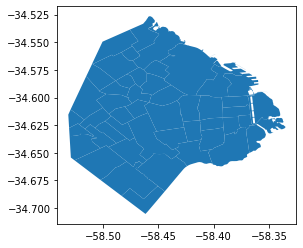

In [27]:
proj = '+proj=tmerc +lat_0=-34.6297166 +lon_0=-58.4627 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs'
bsas_gk = from_wkt(barrios_wkt, 'str_geom', crs=proj)
bsas_gk.plot();

In [28]:
bsas_gk.head()

,Unnamed: 0,BARRIO,COMUNA,PERIMETRO,AREA,OBJETO,str_geom,geometry
0,0,CHACARITA,15.0,7724.852955,3.115707e+06,BARRIO,POLYGON ((-58.4528200492791044 -34.59598865706...,"POLYGON ((-58.45282 -34.59599, -58.45366 -34.5..."
1,1,PATERNAL,15.0,7087.513295,2.229829e+06,BARRIO,POLYGON ((-58.4655768128540672 -34.59655770780...,"POLYGON ((-58.46558 -34.59656, -58.46562 -34.5..."
2,2,VILLA CRESPO,15.0,8131.857075,3.615978e+06,BARRIO,POLYGON ((-58.4237529813036645 -34.59782733832...,"POLYGON ((-58.42375 -34.59783, -58.42495 -34.5..."
3,3,VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06,BARRIO,POLYGON ((-58.4946097568899006 -34.61486523952...,"POLYGON ((-58.49461 -34.61487, -58.49479 -34.6..."
4,4,ALMAGRO,5.0,8537.901368,4.050752e+06,BARRIO,POLYGON ((-58.4128700313088487 -34.61411625158...,"POLYGON ((-58.41287 -34.61412, -58.41282 -34.6..."


In [29]:
bsas_gk.crs.is_projected

True

In [30]:
bsas_gk.crs

<Projected CRS: +proj=tmerc +lat_0=-34.6297166 +lon_0=-58.4627 +k= ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Transverse Mercator
Datum: Unknown based on International 1909 (Hayford) ellipsoid
- Ellipsoid: International 1909 (Hayford)
- Prime Meridian: Greenwich

In [31]:
bsas_gk.crs.name

'unknown'

In [32]:
bsas_gk.crs.datum

DATUM["Unknown based on International 1909 (Hayford) ellipsoid",
    ELLIPSOID["International 1909 (Hayford)",6378388,297,
        LENGTHUNIT["metre",1,
            ID["EPSG",9001]]]]

In [33]:
print(bsas_gk.crs.to_epsg())

None


### Puntos, las estaciones de Ecobici ...

En el paso anterior, creamos un geodataframe cuya geoemtría principal eran polígonos. Ahora, vamos a hacer algo similar aunque con otro tipo de geometría. Vamos a levantar un geodataframe de puntos, con la ubicación de las estaciones EcoBici a partir de coordeandas x e y específicas.

In [34]:
# leemos el csv
estaciones = pd.read_csv('https://raw.githubusercontent.com/PyMap/datahouse/main/ecobici/nuevas-estaciones-bicicletas-publicas.csv')

In [36]:
estaciones.sample(4)

,lat,long,nombre_estacion,id_estacion,capacidad,dirección_completa,direccion_nombre,direccion_altura,direccion_interseccion,barrio
160,-34.550293,-58.476417,399 - GARCIA DEL RIO,268,28,GARCIA DEL RIO & PINTO,GARCIA DEL RIO,NaN,PINTO,Saavedra
177,-34.551327,-58.454186,289 - MONTAÑESES,322,20,2786 Montañeses,Montañeses,2786.0,NaN,Belgrano
159,-34.621795,-58.457528,270 - PLAZA DEL ANGEL GRIS,263,12,Calcena & Avellaneda Av.,Calcena,NaN,Avellaneda Av.,Flores
114,-34.578048,-58.435247,182 - RAVIGNANI Y GUATEMALA,182,20,"2185 Ravignani, Emilio, Dr. & Guatemala","2185 Ravignani, Emilio, Dr.",2185.0,Guatemala,Palermo


In [37]:
from shapely.geometry import Point

In [38]:
list(zip(estaciones['long'], estaciones['lat']))

[(-58.37471510000001, -34.59242329999999),
 (-58.3682604, -34.611032),
 (-58.368762800000006, -34.6017255),
 (-58.420954200000004, -34.580549700000006),
 (-58.369758, -34.628526),
 (-58.381098, -34.606497999999995),
 (-58.3893364, -34.6094218),
 (-58.407741, -34.585443),
 (-58.38880699999999, -34.5927096),
 (-58.406000000000006, -34.61009),
 (-58.426387, -34.577424),
 (-58.418730599999996, -34.606410100000005),
 (-58.44177560000001, -34.5798619),
 (-58.406431999999995, -34.640111),
 (-58.3825498, -34.5938629),
 (-58.379836, -34.600139),
 (-58.380894299999994, -34.610583),
 (-58.416117799999995, -34.5894269),
 (-58.3638723, -34.600752),
 (-58.3900887, -34.599068),
 (-58.4335573, -34.6079414),
 (-58.3973698, -34.5908211),
 (-58.37359839999999, -34.60720739999999),
 (-58.3989807, -34.5970909),
 (-58.371846999999995, -34.596424600000006),
 (-58.38284029999999, -34.59704970000001),
 (-58.4076348, -34.6364511),
 (-58.380030700000006, -34.6046074),
 (-58.3900194, -34.583918),
 (-58.4138829000

In [39]:
def point_from_coord(df, x, y, crs):
  '''
  Carga un geodataframe de puntos a partir de un par de coordenadas lat/lon
  '''
  df['coordenadas'] = list(zip(df[x], df[y]))
  df['geometry'] = df['coordenadas'].map(Point)
  df_sin_coord = df.drop(columns=['coordenadas',x,y])
  gdf = gpd.GeoDataFrame(df_sin_coord, geometry='geometry', crs=crs) 

  return gdf

In [40]:
# creamos el gdf de estaciones
gdf = point_from_coord(estaciones, 'long', 'lat', 4326)

In [41]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

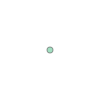

In [42]:
gdf.geometry.iloc[2]

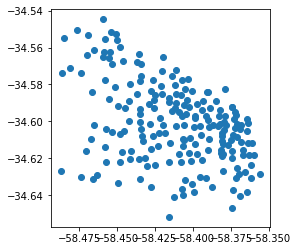

In [43]:
gdf.plot();

In [44]:
# acá, otra forma de crear un geodataframe de puntos a partir de un conjunto de coordenadas
gdf_test = gpd.GeoDataFrame(estaciones, crs=proj, 
                            geometry=gpd.points_from_xy(estaciones['long'], estaciones['lat']))

In [45]:
gdf_test.head(2)

,lat,long,nombre_estacion,id_estacion,capacidad,dirección_completa,direccion_nombre,direccion_altura,direccion_interseccion,barrio,coordenadas,geometry
0,-34.592423,-58.374715,002 - Retiro I,2,20,"Ramos Mejia, Jose Maria, Dr. Av. & Del Liberta...","Ramos Mejia, Jose Maria, Dr. Av.",NaN,Del Libertador Av.,Retiro,"(-58.37471510000001, -34.59242329999999)",POINT (-58.37472 -34.59242)
1,-34.611032,-58.368260,003 - ADUANA,3,20,Moreno & Av Paseo Colon,Moreno,NaN,Av Paseo Colon,Monserrat,"(-58.3682604, -34.611032)",POINT (-58.36826 -34.61103)


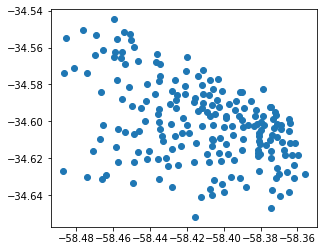

In [46]:
gdf_test.plot();

# Recapitulando, dos formas de visualizar

> **Eje único (superponiendo capas)**

In [47]:
barrios_proj = from_wkt(barrios_wkt, 'str_geom', crs=4326).to_crs(proj)
estaciones_proj = point_from_coord(estaciones, 'long', 'lat', 4326).to_crs(proj)

In [48]:
import matplotlib.pyplot as plt

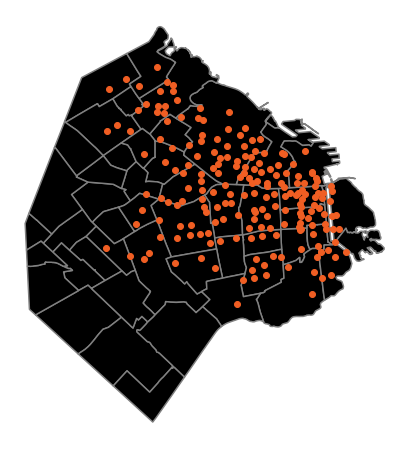

In [49]:
fig, ax = plt.subplots(figsize=(12,8))

barrios_proj.plot(ax=ax, color='black', edgecolor='grey', linewidth=1.5)

estaciones_proj.plot(ax=ax, color='#F05E23')
ax.set_axis_off();

In [50]:
estaciones.sample(3)

,lat,long,nombre_estacion,id_estacion,capacidad,dirección_completa,direccion_nombre,direccion_altura,direccion_interseccion,barrio,coordenadas,geometry
157,-34.616207,-58.440700,272 - Plaza Bruno Giordano,261,16,Bruno Giordano&Neuquen,Bruno Giordano&Neuquen,NaN,Neuquen,Caballito,"(-58.4406995, -34.616207)",POINT (-58.4406995 -34.616207)
66,-34.612769,-58.376941,098 - Belgrano y roca,98,16,Av Belgrano 705,Av Belgrano,705.0,NaN,Monserrat,"(-58.3769407, -34.6127689)",POINT (-58.3769407 -34.6127689)
111,-34.626814,-58.380679,147 - Constitución,175,36,Avenida Juan de Garay 1050,Avenida Juan de Garay,1050.0,NaN,Constitucion,"(-58.380679, -34.626814)",POINT (-58.380679 -34.626814)


In [51]:
df = pd.read_csv('https://storage.googleapis.com/python_mdg/data_cursos/bici18_cdn.csv')

In [52]:
df.sample(3)

,bici_id_usuario,bici_Fecha_hora_retiro,bici_tiempo_uso,bici_nombre_estacion_origen,bici_estacion_origen,bici_nombre_estacion_destino,bici_estacion_destino,bici_sexo,bici_edad
738204,236683.0,2018-10-03 21:57:24,102.0,Plaza Primero de Mayo,75,Sarandí,77.0,MASCULINO,57.0
2288590,41827.0,2018-05-09 17:09:06,21.0,Bouchard,55,Montevideo,27.0,MASCULINO,53.0
1865300,159527.0,2018-06-22 17:37:41,16.0,Catamarca,186,Billinghurst,66.0,MASCULINO,29.0


In [53]:
# Creamos la cantidad total de retiros en origen para el año 2018
retiros_en_origen = df.groupby(['bici_nombre_estacion_origen',
                                'bici_estacion_origen'])[['bici_sexo']].count().reset_index()

In [54]:
retiros_en_origen

,bici_nombre_estacion_origen,bici_estacion_origen,bici_sexo
0,15 de Noviembre,105,4966
1,25 de Mayo,60,11750
2,9 de Julio,112,8363
3,Acevedo,136,16853
4,Acuña de Figueroa,54,24843
...,...,...,...
196,Vera Peñaloza,150,26708
197,Villarroel,158,8722
198,Virrey Cevallos,183,25584
199,Virrey Liniers,139,8544


In [55]:
# ... y lo mergeamos con nuestro shape de estaciones
retiros_en_origen_map = pd.merge(estaciones_proj,retiros_en_origen, 
                                 left_on='id_estacion', 
                                 right_on='bici_estacion_origen')

In [56]:
retiros_en_origen_map

,nombre_estacion,id_estacion,capacidad,dirección_completa,direccion_nombre,direccion_altura,direccion_interseccion,barrio,geometry,bici_nombre_estacion_origen,bici_estacion_origen,bici_sexo
0,002 - Retiro I,2,20,"Ramos Mejia, Jose Maria, Dr. Av. & Del Liberta...","Ramos Mejia, Jose Maria, Dr. Av.",NaN,Del Libertador Av.,Retiro,POINT (108071.943 104133.650),Retiro,2,17426
1,003 - ADUANA,3,20,Moreno & Av Paseo Colon,Moreno,NaN,Av Paseo Colon,Monserrat,POINT (108662.180 102068.743),Aduana,3,6756
2,004 - Plaza Roma,4,20,Lavalle & Bouchard,Lavalle,NaN,Bouchard,San nicolas,POINT (108617.061 103101.211),Plaza Roma,4,14935
3,005 - Plaza Italia,5,42,Av. Sarmiento 2601,Av. Sarmiento,2601.0,NaN,Palermo,POINT (103830.403 105453.581),Plaza Italia,5,35698
4,006 - Parque Lezama,6,20,"Avenida Martin Garcia, 295","Avenida Martin Garcia,",295.0,NaN,San telmo,POINT (108523.029 100128.153),Parque Lezama,6,15010
...,...,...,...,...,...,...,...,...,...,...,...,...
122,194 - PERÓN Y ACUÑA DE FIGUEROA,194,16,3997 TTE. GENERAL JUAN DOMINGO PERON,TTE. GENERAL JUAN DOMINGO PERON,3997.0,NaN,Almagro,POINT (103690.787 102621.882),Peron y F. Acuña de Figueroa,194,15645
123,196 - HOSPITAL ARGERICH,196,20,750 Pi Y Margall & Necochea,750 Pi Y Margall,750.0,Necochea,Boca,POINT (108893.329 100237.731),Hospital Argerich,196,5251
124,197 - Quintino Bocayuva,197,20,Quintino Bocayuva y Don Bosco,Quintino Bocayuva y Don Bosco,NaN,NaN,Almagro,POINT (103604.850 101803.963),Quintino Bocayuva,197,12281
125,199 - ESTADOS UNIDOS Y BOEDO,199,20,3568 Estados Unidos & Boedo Av.,3568 Estados Unidos,3568.0,Boedo Av.,Boedo,POINT (104281.579 100826.205),EEUU y Boedo,199,17004


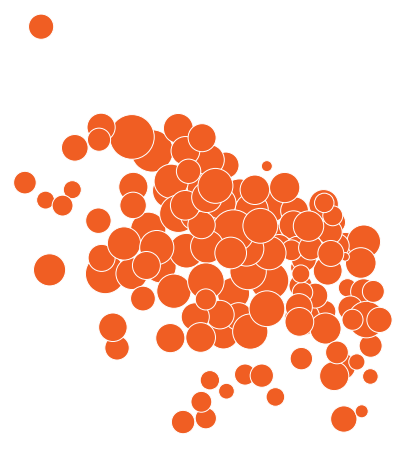

In [57]:
# un primer pantallazo de nuestras estaciones
fig, ax =plt.subplots(figsize=(15,8))
retiros_en_origen_map.plot(ax=ax, 
                           markersize=retiros_en_origen_map['bici_sexo']*0.05, 
                           color='#F05E23', edgecolor='white')
ax.set_axis_off();

### Breve digresión sobre la disposición de un gráfico en ejes

En las clases anteriores, vimos que un aspecto clave dentro de las visualizaciones es lo que en mucho código aparece como `ax`: los ejes. Es importante retener algunas de las cuestiones que están por detrás de esta lógica para poder tener cierta independecia de recursos a la hora de elegir lo que queremos hacer. 

Generalmente, cuando ploteamos un mapa, queremos ver o bien la relación entre geometrías (un caso podría ser nuestro mapa de estaciones y barrios) o bien comparar una misma geometría en dos situaciones diferentes (por ejemplo, un mapa de estaciones en días distintos).

Por eso, podríamos decir que existen dos grandes variantes:

> **Ejes simples (capas supuerpuestas)**

Este caso, corresponde a la disposición del gráfico en un eje. Para ello, debemos saber que los métodos `subplot` o `add_subplot de `matplotlib` nos permiten disponer un eje de distintas maneras. Esto se hace especificando tres valores:

*a.* La cantidad de filas

*b.* La cantidad de columnas

*c.* La posición o índice

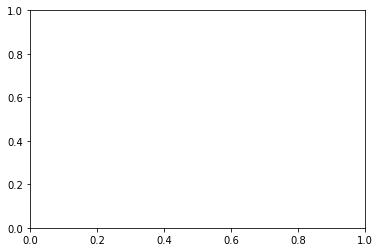

In [58]:
# este sería el primer eje en una disposición de una fila y una columna
plt.subplot(1,1,1);

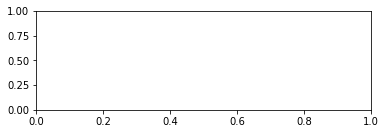

In [59]:
# el eje se puede dividir en dos, siguiendo la línea de una columna. El nrows == 2 disminuye el alto de cada eje.
plt.subplot(2,1,1);

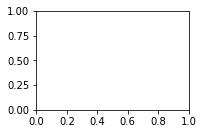

In [60]:
# esto queda más claro cuando vemos que si dividimos en columnas, el eje vuelve a particionarse
plt.subplot(2,2,1);

Esto tiene cierto sentido, si tenemos en cuenta que la partición de un eje en filas y columnas suele ser funcional a la hora de agregar muchos gráficos en un mismo plot. 

> **Ejes múltiples (mapas comparativos)**

Este es el caso de los ejes múltiples. Un recurso bastante útil a la hora de armar mapas comaprativos, como una misma choropleta con distintos esquemas de claseficación. O bien la cantidad de retiros de bicicletas en momentos o ubicaciones diferentes

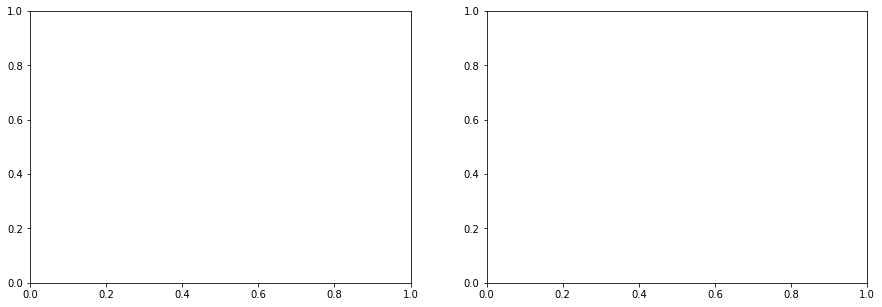

In [61]:
# una fila en dos columnas
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

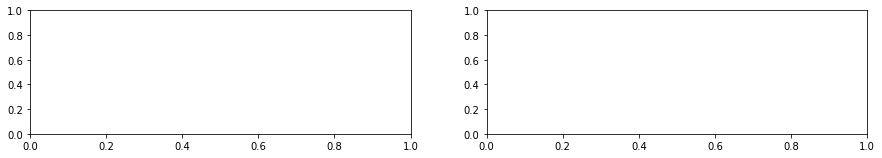

In [62]:
# dos filas en dos columnas
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

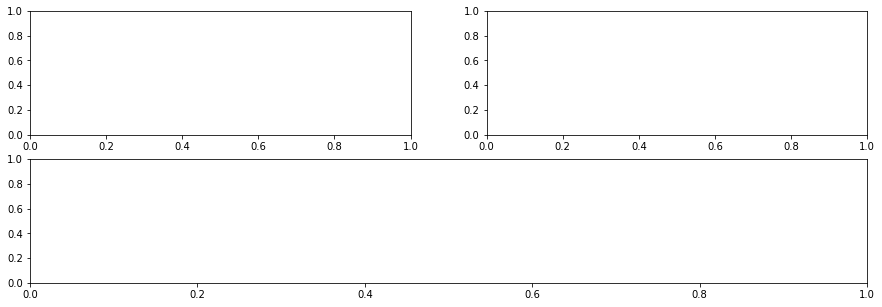

In [63]:
# un eje dividido en dos filas y en dos columnas y otro igual pero en una columna
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,1,2)

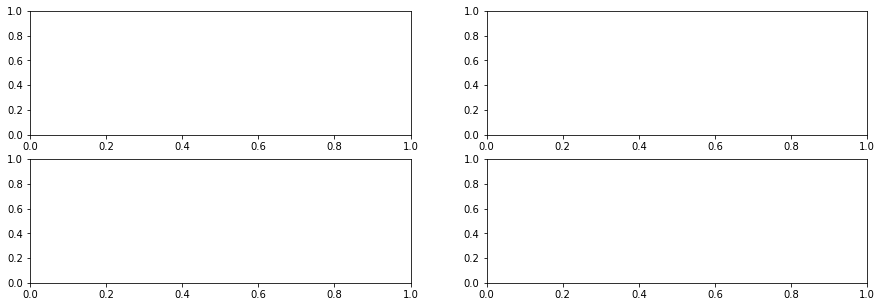

In [64]:
# en dos filas y dos columnas, con mas posiciones
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

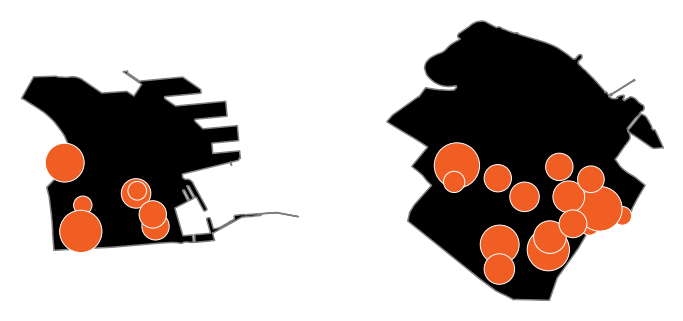

In [65]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# barrio 1
barrios_proj.loc[barrios_proj['BARRIO']=='RETIRO'].plot(ax=ax1, color='black', 
                                                        edgecolor='grey', linewidth=1.5)
retiros_en_origen_map.loc[retiros_en_origen_map['barrio']=='Retiro'].plot(ax=ax1, 
                                                                          markersize=retiros_en_origen_map['bici_sexo']*0.05, 
                                                                          color='#F05E23', edgecolor='white')

#barrio 2
barrios_proj.loc[barrios_proj['BARRIO']=='PALERMO'].plot(ax=ax2, color='black', 
                                                         edgecolor='grey', linewidth=1.5)
retiros_en_origen_map.loc[retiros_en_origen_map['barrio']=='Palermo'].plot(ax=ax2, 
                                                                           markersize=retiros_en_origen_map['bici_sexo']*0.05, 
                                                                           color='#F05E23', edgecolor='white')

ax1.set_axis_off()
ax2.set_axis_off();

# Operaciones geográficas 

El análisis espacial, muchas veces nos demanda realizar distintos tipos de manipulaciones sobre geometrías u objetos espaciales. Por ejemplo, podríamos necesitar recortar una capa en función de otra base, agregar etiquetas provenientes de capas de superposición, ver delimitaciones establecidas entre dos o más capas que intersectan, etc, etc.

Esto, con la finalidad de de responder preguntas específicas. Por ejemplo, imaginemos que necesitamos conocer la cantidad de retiros de bicicletas a un nivel de agregación mayor. Digamos, comunas.

> **join espacial**

GeoPandas permie, así como Pandas, realizar joins según columnas, a través de **merge** o **join**. Además, GeoPandas agrega la posibilidad de unir dos GeoDataFrames según una operación espacial. El método a emplear es **.sjoin** que tiene dos parámetros importantes: 

- how: que permite establecer si es un *left*, un *right* o un *inner*.

- op: consta de 3 operaciones geográficas:

    **intersects (interseca)**: los atributos se van a joinear si el límite o el interior de un objeto (geográfico) se interseca con el límite o el interior del otro objeto geográfico.
    
    **within (dentro)**: los atributos se van a joinear si el límite o el interior de un objeto (geográfico) se interseca sólo con el interior del otro objeto geográfico.

    **contains (contiene)**: los atributos se van a joinear si el interior del objeto contiene la frontera y el interior del otro objeto y sus límites no se tocan.


Puede consultarse la documentación en: http://geopandas.org/mergingdata.html

In [66]:
comunas = gpd.read_file('/drive/MyDrive/IT - UNSAM/datos/comunas.zip')

In [67]:
# Primero veamos en qué coordenadas están las capas que queremos unir
comunas.crs == retiros_en_origen_map.crs

False

In [68]:
# Es el mismo? podemos realizar la operación con tranquilidad?
retiros_comuna = gpd.sjoin(retiros_en_origen_map, comunas, how='left', op='within')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +proj=tmerc +lat_0=-34.6297166 +lon_0=-58.4627 +k= ...
Right CRS: PROJCS["Argentina_GKBsAs",GEOGCS["Campo Inchauspe" ...

  


In [69]:
# reproyectemos!
retiros_comuna = gpd.sjoin(retiros_en_origen_map, comunas.to_crs(proj), how='left', op='within')

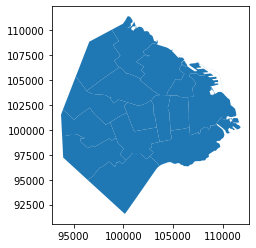

In [70]:
comunas.plot()

In [75]:
comunas

,BARRIOS,PERIMETRO,AREA,COMUNAS,ID,OBJETO,geometry
0,RECOLETA,21452.838648,6.317265e+06,2.0,1,LIMITE COMUNAL,"POLYGON ((107643.458 106569.299, 107641.492 10..."
1,ALMAGRO - BOEDO,12323.432479,6.660603e+06,5.0,2,LIMITE COMUNAL,"POLYGON ((104625.143 101679.935, 104629.994 10..."
2,CABALLITO,10990.964471,6.851029e+06,6.0,3,LIMITE COMUNAL,"POLYGON ((102998.760 102464.802, 103002.947 10..."
3,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,7.0,4,LIMITE COMUNAL,"POLYGON ((101036.604 99947.208, 101075.002 998..."
4,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,9.0,5,LIMITE COMUNAL,"POLYGON ((94869.346 99583.645, 94885.072 99583..."
5,FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...,18332.037457,1.265656e+07,10.0,6,LIMITE COMUNAL,"POLYGON ((97703.854 101010.270, 97716.104 1009..."
6,VILLA DEL PARQUE - VILLA DEVOTO - VILLA GRAL....,19987.696155,1.412004e+07,11.0,7,LIMITE COMUNAL,"POLYGON ((96781.486 103649.395, 96892.479 1035..."
7,COGHLAN - SAAVEDRA - VILLA PUEYRREDON - VILLA ...,17232.189372,1.557093e+07,12.0,8,LIMITE COMUNAL,"POLYGON ((96329.447 103927.833, 96314.729 1039..."
8,PALERMO,22126.531858,1.584587e+07,14.0,9,LIMITE COMUNAL,"POLYGON ((103353.744 108568.622, 103353.843 10..."
9,BALVANERA - SAN CRISTOBAL,10486.260809,6.385991e+06,3.0,10,LIMITE COMUNAL,"POLYGON ((104713.283 103467.380, 104862.315 10..."


In [76]:
retiros_comuna.COMUNAS

0       1.0
1       1.0
2       1.0
3      14.0
4       1.0
       ... 
122     5.0
123     4.0
124     5.0
125     5.0
126     2.0
Name: COMUNAS, Length: 127, dtype: float64

Esta operación nos permitiría comparar tanto la cantidad de retiros entre polígonos (puntos graduados) como dentro de los mismos (choropletas). Veamos el primer caso ...

In [83]:
def compara_retiros_totales(comuna_a, comuna_b):
  '''
  Compara cantidad de retiros totales en estaciones de origen
  ...
  Argumentos:
    comuna_a (int): id de la primera comuna
    comuna_b (int): id de la segunda comuna 
  Devuelve
  
  '''
  fig = plt.figure(figsize=(17,12))
  ax1 = fig.add_subplot(1,2,1)
  ax2 = fig.add_subplot(1,2,2)

  # comuna a
  comunas.loc[comunas.COMUNAS == comuna_a].plot(ax=ax1, color='black', edgecolor='grey', linewidth=1.5)
  retiros_comuna.loc[retiros_comuna.COMUNAS == comuna_a].plot(ax=ax1, color='red', 
                                                         edgecolor='white',
                                                         markersize=retiros_comuna['bici_sexo']*0.05).plot()

  # comuna b
  comunas.loc[comunas.COMUNAS == comuna_b].plot(ax=ax2, color='black', edgecolor='grey', linewidth=1.5)
  retiros_comuna.loc[retiros_comuna.COMUNAS == comuna_b].plot(ax=ax2, color='green', 
                                                         edgecolor='white', 
                                                         markersize=retiros_comuna['bici_sexo']*0.05).plot()

  ax1.set_title('Retiros en origen:Comuna {}'.format(comuna_a))
  ax1.set_axis_off()

  ax2.set_title('Retiros en origen:Comuna {}'.format(comuna_b))
  ax2.set_axis_off();

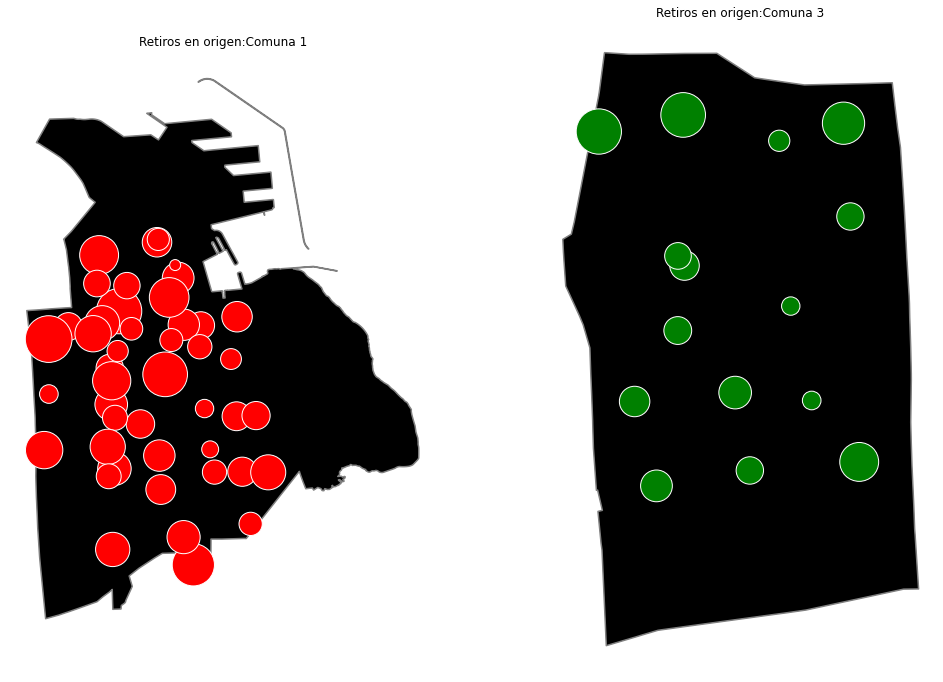

In [87]:
compara_retiros_totales(1, 3)

In [88]:
comunas_agregacion = retiros_comuna.groupby(['COMUNAS'])[['bici_sexo']].sum().reset_index()
retiros_por_comuna = pd.merge(comunas, comunas_agregacion[['COMUNAS','bici_sexo']], 
                              how='left', on='COMUNAS')

In [89]:
!pip install mapclassify

In [90]:
retiros_por_comuna.fillna(0, inplace=True)

In [91]:
# retiros anuales totales por comuna
retiros_por_comuna.head()

,BARRIOS,PERIMETRO,AREA,COMUNAS,ID,OBJETO,geometry,bici_sexo
0,RECOLETA,21452.838648,6.317265e+06,2.0,1,LIMITE COMUNAL,"POLYGON ((107643.458 106569.299, 107641.492 10...",375303.0
1,ALMAGRO - BOEDO,12323.432479,6.660603e+06,5.0,2,LIMITE COMUNAL,"POLYGON ((104625.143 101679.935, 104629.994 10...",154197.0
2,CABALLITO,10990.964471,6.851029e+06,6.0,3,LIMITE COMUNAL,"POLYGON ((102998.760 102464.802, 103002.947 10...",74271.0
3,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,7.0,4,LIMITE COMUNAL,"POLYGON ((101036.604 99947.208, 101075.002 998...",0.0
4,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,9.0,5,LIMITE COMUNAL,"POLYGON ((94869.346 99583.645, 94885.072 99583...",0.0


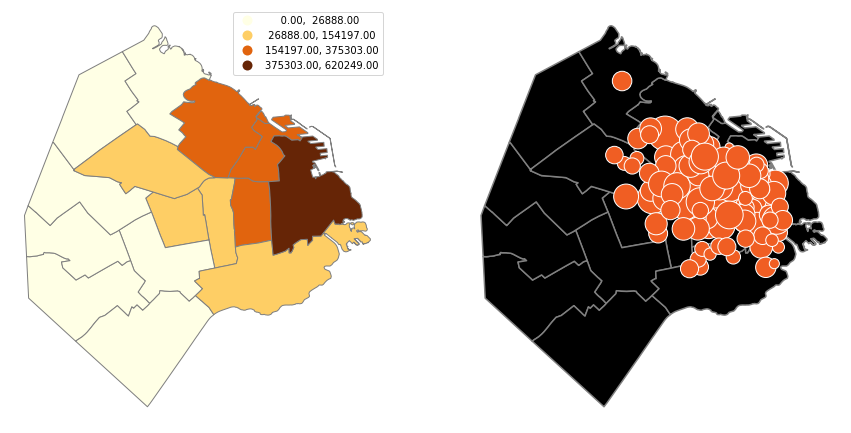

In [92]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

retiros_por_comuna.plot(ax=ax1, column='bici_sexo', 
                        cmap='YlOrBr', edgecolor='grey', 
                        scheme='NaturalBreaks', k=4, legend=True)

comunas.plot(ax=ax2, color='black', edgecolor='grey', linewidth=1.5)
retiros_en_origen_map.plot(ax=ax2,  
                           markersize=retiros_en_origen_map['bici_sexo']*0.03, 
                           #column='bici_sexo', legend=True,
                           color='#F05E23', 
                           edgecolor='white')

ax1.set_axis_off()
ax2.set_axis_off();

Los que quieran ahondar un poco más sobre esquemas de clasificación, acá compartimos el link al siguiente [material complementario](https://github.com/PyMap/MDG/blob/master/Clase%203/03_2_esquemas_clasificacion.ipynb)

> **Overlay y Dissolve**

Otra pregunta que podríamos llegar a querer respondernos es cuál es el área de cobertura del servicio. Supongamos que para poder hacerlo, establecemos como parámetro un buffer de cierta distancia a las estaciones de ecobici. Así, podremos determinar un patrón de cobertura. Esto, combinando los radios de cobertura que se intersectan y determinando el área de la geometría resultante. Para ello, nos valdremos de dos operaciones comunmente utilizadas, el overlay y el dissolve. Dos métodos que se encuentran implementados en geopandas de una manera bastante clara. 

In [97]:
estaciones_buff = estaciones_proj.copy()
estaciones_buff.geometry = estaciones_buff.buffer(300) # dado que las estaciones se encuentran bastante concentradas, definamos un buffer de corto alcance

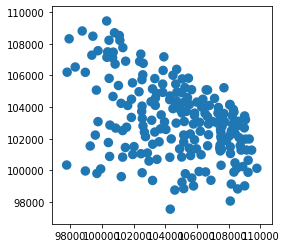

In [98]:
estaciones_buff.plot();

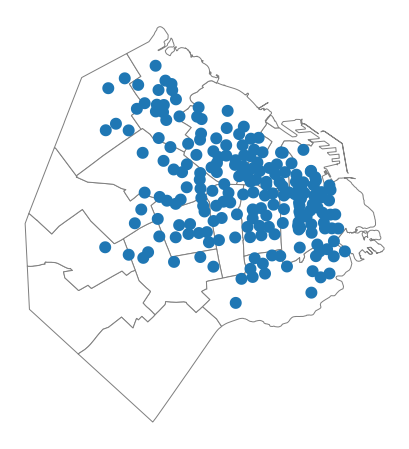

In [99]:
fig, ax = plt.subplots(figsize=(15,8))

comunas.plot(ax=ax, color='white', edgecolor='grey', linewidth=1)
estaciones_buff.plot(ax=ax)

ax.set_axis_off();

Ahora vamos a ver cómo calcular el área cubierta y el área no cubierta. El área cubierta es la **intersección** entre la capa de barrios y la capa de estaciones (con su buffer). Por otro lado, el área no cubierta es la **diferencia** entre la capa de barrios y la capa de bomberos (con su buffer).

In [100]:
interseccion = gpd.overlay(estaciones_buff, comunas.to_crs(proj), how = "intersection")

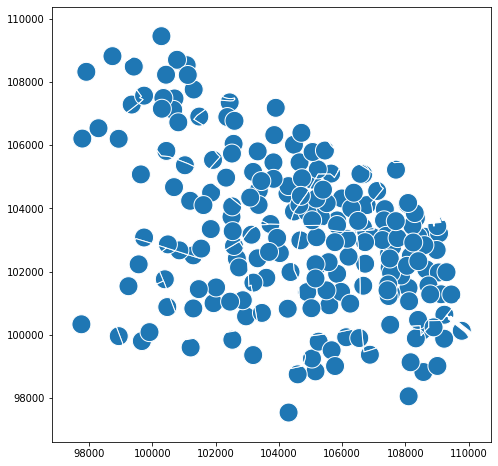

In [101]:
interseccion.plot(figsize=(15,8), edgecolor='white');

In [103]:
# ahora, podemos ver el área de intersección entre buffers
interseccion.geometry.area

0      POLYGON ((108371.943 104133.650, 108370.498 10...
1      POLYGON ((108962.180 102068.743, 108960.736 10...
2      POLYGON ((108917.061 103101.211, 108915.616 10...
3      POLYGON ((108261.366 100274.433, 108273.588 10...
4      POLYGON ((107785.098 102572.754, 107783.653 10...
                             ...                        
261    POLYGON ((100300.377 102630.741, 100281.374 10...
262    POLYGON ((99547.282 101538.055, 99545.837 1015...
263    POLYGON ((99976.105 102892.740, 99972.293 1028...
264    POLYGON ((99076.377 99692.693, 99054.742 99682...
265    POLYGON ((98059.178 100334.601, 98057.734 1003...
Name: geometry, Length: 266, dtype: geometry

Sin embargo, como podemos verlos buffer se superponen, lo que nos estaría haciendo incurrir en el error de contar más de una vez áreas de cobertura. Por eso, debemos primer unir todos los polígonos para evitar errores de duplicación.

Acá es donde entra el método `dissolve`. Este método unifica geometrías bajo una constante. Primero, vamos a generar un agrupamiento para calcular el área de cobertura en toda la Ciudad. Lógicamente, esta lógica se podría replicar para grupos de comunas, haciendo el filtrado correspondiente.

In [104]:
# creamos una constante
interseccion["const"] = 0

In [105]:
interseccion.head()

,nombre_estacion,id_estacion,capacidad,dirección_completa,direccion_nombre,direccion_altura,direccion_interseccion,barrio,BARRIOS,PERIMETRO,AREA,COMUNAS,ID,OBJETO,geometry,const
0,002 - Retiro I,2,20,"Ramos Mejia, Jose Maria, Dr. Av. & Del Liberta...","Ramos Mejia, Jose Maria, Dr. Av.",NaN,Del Libertador Av.,Retiro,CONSTITUCION - MONSERRAT - PUERTO MADERO - RE...,36102.201573,1.779457e+07,1.0,14,LIMITE COMUNAL,"POLYGON ((108371.943 104133.650, 108370.498 10...",0
1,003 - ADUANA,3,20,Moreno & Av Paseo Colon,Moreno,NaN,Av Paseo Colon,Monserrat,CONSTITUCION - MONSERRAT - PUERTO MADERO - RE...,36102.201573,1.779457e+07,1.0,14,LIMITE COMUNAL,"POLYGON ((108962.180 102068.743, 108960.736 10...",0
2,004 - Plaza Roma,4,20,Lavalle & Bouchard,Lavalle,NaN,Bouchard,San nicolas,CONSTITUCION - MONSERRAT - PUERTO MADERO - RE...,36102.201573,1.779457e+07,1.0,14,LIMITE COMUNAL,"POLYGON ((108917.061 103101.211, 108915.616 10...",0
3,006 - Parque Lezama,6,20,"Avenida Martin Garcia, 295","Avenida Martin Garcia,",295.0,None,San telmo,CONSTITUCION - MONSERRAT - PUERTO MADERO - RE...,36102.201573,1.779457e+07,1.0,14,LIMITE COMUNAL,"POLYGON ((108261.366 100274.433, 108273.588 10...",0
4,007 - OBELISCO,7,16,CARLOS PELEGRINI 215,CARLOS PELEGRINI,215.0,None,San nicolas,CONSTITUCION - MONSERRAT - PUERTO MADERO - RE...,36102.201573,1.779457e+07,1.0,14,LIMITE COMUNAL,"POLYGON ((107785.098 102572.754, 107783.653 10...",0


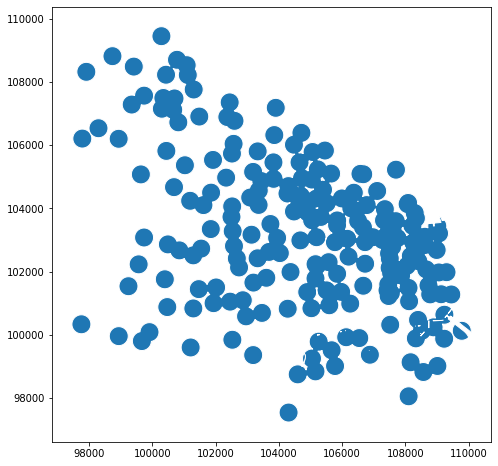

In [106]:
interseccion.dissolve(by="const").plot(figsize=(15,8), edgecolor='white'); 

In [107]:
area_de_cobertura = interseccion.dissolve(by="const")

In [108]:
# vemos que es una sola geometría
len(area_de_cobertura)

1

In [109]:
# de tipo multipolígono
area_de_cobertura.geometry

const
0    MULTIPOLYGON (((108630.246 99848.274, 108627.6...
Name: geometry, dtype: geometry

In [110]:
area_de_cobertura

,geometry,nombre_estacion,id_estacion,capacidad,dirección_completa,direccion_nombre,direccion_altura,direccion_interseccion,barrio,BARRIOS,PERIMETRO,AREA,COMUNAS,ID,OBJETO
const,,,,,,,,,,,,,,,
0,"MULTIPOLYGON (((108630.246 99848.274, 108627.6...",002 - Retiro I,2,20,"Ramos Mejia, Jose Maria, Dr. Av. & Del Liberta...","Ramos Mejia, Jose Maria, Dr. Av.",295.0,Del Libertador Av.,Retiro,CONSTITUCION - MONSERRAT - PUERTO MADERO - RE...,36102.201573,1.779457e+07,1.0,14,LIMITE COMUNAL


In [114]:
area_de_cobertura.geometry.area.values[0]

45318354.90014282

In [115]:
km2_cobertura = area_de_cobertura.geometry.area.values[0]/1000000
print("El área cubierta dentro de un buffer de 300 metros es de %r km2"%km2_cobertura)

El área cubierta dentro de un buffer de 300 metros es de 45.31835490014282 km2


In [116]:
porcentaje_cub = round(area_de_cobertura.geometry.area/comunas.geometry.area.sum()*100,2).values[0]
print("Lo que representa un total del {}% respecto del área total de la ciudad".format(porcentaje_cub))

Lo que representa un total del 22.21% respecto del área total de la ciudad


También podríamos haber calculado el área no cubierta dentro de un buffer de 300mts a las estaciones de EcoBici. Para eso, la operación a ser utilizada hubiese sido `difference` en lugar de `intersect`.

In [117]:
diferencia = gpd.overlay(comunas.to_crs(proj), estaciones_buff, how = "difference")

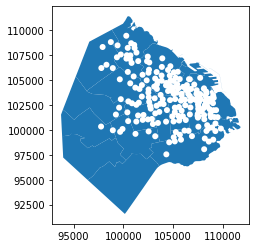

In [118]:
# aca vemos el area no cubierta
diferencia.plot();

In [119]:
diferencia["const"] = 0
area_no_cubierta = diferencia.dissolve(by='const')

In [120]:
km2_no_cubierta = area_no_cubierta.geometry.area.values[0]/1000000
print("El área cubierta dentro de un buffer de 300 metros es de %r km2"%km2_no_cubierta)

El área cubierta dentro de un buffer de 300 metros es de 158.75036213048122 km2


In [121]:
porcentaje_des = round(area_no_cubierta.geometry.area/comunas.geometry.area.sum()*100,2).values[0]
print("Lo que representa un total del {}% respecto del área total de la ciudad".format(porcentaje_des))

Lo que representa un total del 77.79% respecto del área total de la ciudad


In [122]:
# el area de la ciudad
porcentaje_cub + porcentaje_des

100.0